# Анализ совершенных покупок

## Описание признакового пространства

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

|Признак|Описание признака|
|-------------:|:------------|
|customer_id |позаказный идентификатор пользователя|
|customer_unique_id |уникальный идентификатор пользователя  (аналог номера паспорта)|
|customer_zip_code_prefix |почтовый индекс пользователя|
|customer_city |город доставки пользователя|
|customer_state |штат доставки пользователя|

olist_orders_dataset.csv —  таблица заказов

|Признак|Описание признака|
|-------------:|:------------|
|order_id  |уникальный идентификатор заказа (номер чека)|
|customer_id |позаказный идентификатор пользователя|
|order_status |статус заказа|
|order_purchase_timestamp |время создания заказа|
|order_approved_at |время подтверждения оплаты заказа|
|order_delivered_carrier_date |время передачи заказа в логистическую службу|
|order_delivered_customer_date |время доставки заказа|
|order_estimated_delivery_date |обещанная дата доставки|

Уникальные статусы заказов в таблице olist_orders_dataset:

|Статус|Описание статуса|
|-------------:|:------------|
|created  |создан|
|approved  |подтверждён|
|invoiced  |выставлен счёт|
|processing  |в процессе сборки заказа|
|shipped  |отгружен со склада|
|delivered  |доставлен пользователю|
|unavailable  |недоступен|
|canceled  |отменён|

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

|Признак|Описание признака|
|-------------:|:------------|
|order_id  |уникальный идентификатор заказа (номер чека)|
|order_item_id   |идентификатор товара внутри одного заказа|
|product_id   |ид товара (аналог штрихкода)|
|seller_id  |ид производителя товара|
|shipping_limit_date  |максимальная дата доставки продавцом для передачи заказа партнеру по логистике|
|price  |цена за единицу товара|
|freight_value   |вес товара|

## Вопросы на которые необходимо ответить в ходе выполнения проекта

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.(10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.(35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.





In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams

rcParams["figure.figsize"] = 12, 8

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
order_items = pd.read_csv('olist_order_items_dataset.csv')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [5]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
# проверим пропущенные значения
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [7]:
# проверим типы данных
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [8]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
# проверим пропущенные значения
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [10]:
# проверим типы данных
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [11]:
# переведем колонку shipping_limit_date к типу datetime 
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

In [12]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [13]:
# проверим пропущенные значения
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [14]:
# проверим типы данных
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [15]:
# проанализируем пропущенные значения
orders.query("order_approved_at == 'NaT'").order_status.value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

In [16]:
orders.query("order_delivered_carrier_date == 'NaT'").order_status.value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: order_status, dtype: int64

In [17]:
orders.query("order_status == 'delivered' & order_delivered_carrier_date == 'NaT'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


In [18]:
orders.query("order_delivered_customer_date == 'NaT'").order_status.value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

In [19]:
orders.query("order_delivered_customer_date == 'NaT' & order_status == 'delivered'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


|№|Признак|Расшифровка|Проблемы с признаком|
|-:|-------------:|:------------|:------------|
|1|order_approved_at|время подтверждения оплаты заказа | 141 - это отмененные заказы, которые не успели оплатить логично, что по ним нет ни времени подтверждения оплаты, ни времени доставки, но имеется обещанная дата доставки, пока не понятно откуда он рассчитывается 5 - это только созданные заказы и еще не оплаченные заказы, поэтому по ним нет времени времени подтверждения оплаты и доставки 14 - это заказы доставленные пользователю, но при этом не оплаченные, получается не всегда факт оплаты является переходом права собственности на товар (возможно в договоре имеется информация об оплате частями и т.п.)
|2|order_delivered_carrier_date|время передачи заказа в логистическую службу | 609 - заказы со статусом unavailable до конца не понятно, что этот стасус означает, имеется время подтверждения товара, но в достаку еще не передано 550 - отмененные и еще не переданные в доставку товары 314 - товары по которым выставлен счет, но не переданы в доставку 301 - товары в процессе сборки 5 - созданные и еще не оплаченные товары, не переданные в доставку 2 - подтвержден и не передан в доставку 2 - эти два заказа имеют статус доставлено, по одному заказу 2aa91108853cecb43c84a5dc5b277475 имеется дата доставки заказа, но отсутсвует дата передачи в логистическую службу. по второму заказу 2d858f451373b04fb5c984a1cc2defaf указан статус delivered, но при этом нет информации о дате передачи в логистическую службу и времени доставки заказа, возможно имеет место ошибочный статус заказа 2 - имеют статус подтверждено, возможно еще не переданы в логистическую службу
|3|order_delivered_customer_date|время доставки заказа | вопрос возникает только по 8 заказам со статусом доставлено, но при этом по ним отсутствует время доставки покупателю, возможно имеет место ошибочный статус заказа, либо курьеры не отметили факт передачи заказа покупателю. Эти 8 заказов нужно удалить, либо поменять их статус 7 заказов на shipped, и статус одного на processing, так как у него отсутсвует дата передачи заказа в логистическую службу

In [20]:
# для проверки
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [21]:
# поменяем статусы в заказах, по которым отсутствует дата доставки, но имеется статус delivered

orders.iloc[[3002, 20618, 43834, 79263, 82868, 97647, 98038], [2]] = 'shipped'

In [22]:
orders.iloc[[92643], [2]] = 'processing'

In [23]:
# проверим, что замены произведены корректно 
orders.order_status.value_counts()

delivered      96470
shipped         1114
canceled         625
unavailable      609
invoiced         314
processing       302
created            5
approved           2
Name: order_status, dtype: int64

In [24]:
# проверим данные на наличие дубликатов

In [25]:
order_items.duplicated().sum()

0

In [26]:
customers.duplicated().sum()

0

In [27]:
orders.duplicated().sum()

0

In [28]:
# посмотрим основные статистические характеристики
order_items.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,95%,99%,max
order_item_id,112650.0,1.197834,0.705124,1.00,1.0000,1.00,1.00,1.00,1.00,1.00,2.00,4.00,21.00
price,112650.0,120.653739,183.633928,0.85,9.9900,17.00,23.80,39.90,74.99,134.90,349.90,890.00,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,4.4198,7.78,8.73,13.08,16.26,21.15,45.12,84.52,409.68


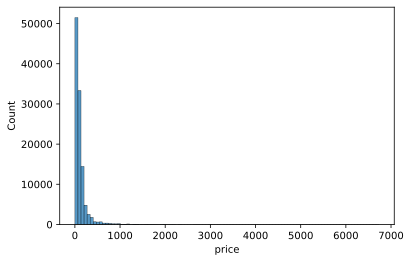

In [29]:
sns.histplot(data=order_items, x='price', bins=100);

Основная масса заказов (почти 99%) не превышает стоимость 900 денежных единиц, однако имеются и достаточно дорогие заказы стоимостью почти 7000 денежных единиц. Из-за этого распределение смещено сильно вправо.

### Что будем считать покупкой

Проведя предварительное исследование данных, можно сделать вывод, что судя по тому какие уникальные статусы могут присваиваться заказу, мы имеем дело с неким интернет-магазином, так как заказ проходит различные стадии от создания заказа до конечного вручения его покупателю.

Покупки через интернет относятся к розничной купле-продаже. Если покупатель не имеет возможности непосредственно ознакомиться с самим товаром или его образцом, а ему предлагается только картинка товара (в данном случае на сайте интернет-магазина), то такой способ торговли называется дистанционным способом продажи товаров.

Продавец обязан заключить договор купли-продажи товара с любым лицом, который хочет приобрести товар, причем подписывать такой договор не обязательно. Согласно п. 20 «Правил продажи товаров дистанционным способом», установленных Постановлением Правительства РФ от 27.09.2007 г. N 612, такой договор считается заключенным:

- с момента выдачи продавцом покупателю кассового или товарного чека либо иного документа, подтверждающего оплату товара;

-  или с момента получения продавцом сообщения о намерении покупателя приобрести товар.

Получается, что факт оплаты в нашем случае это будет факт заключения договора.

При покупке через интернет-магазин переход права собственности на товар от продавца к покупателю происходит именно в момент вручения товара последнему, это предусмотрено с п. 2 ст. 499 ГК РФ «договор розничной купли-продажи по общему правилу считается исполненным с момента вручения товара покупателю, а при его отсутствии — любому лицу, предъявившему квитанцию или иной документ, свидетельствующий о заключении договора или об оформлении доставки товара».

Именно момент переходв права собственноти на товар (факт доставки покупателю) и будем считать покупкой для дальнейшего анализа, т.е покупкой будут считаться те заказы, у которых имеется статус "delivered".


UPD: Судя по названию штатов и городов в таблице olist_customers_datase речь идет о Бразилии, и законодательство об интернет-покупках там может отличаться от российского, но так как изучение законодательва другой страны процесс достаточно длительный, то в рамках нашего анализа предположим, что оно не отличается.   



### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [30]:
orders_customers = orders.merge(customers, on='customer_id')

In [31]:
orders_customers \
        .query("order_status == 'delivered'") \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'order_id' : 'count'}) \
        .rename(columns={'order_id' : 'purchases_count'}) \
        .query("purchases_count == 1") \
        .count().purchases_count

90549

In [32]:
# сделаем проверку
orders_customers \
        .query("order_status == 'delivered'") \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'order_id' : 'count'}) \
        .rename(columns={'order_id' : 'purchases_count'}) \
        .count().purchases_count \
        - orders_customers \
        .query("order_status == 'delivered'") \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'order_id' : 'count'}) \
        .rename(columns={'order_id' : 'purchases_count'}) \
        .query("purchases_count > 1") \
        .count().purchases_count

90549

#### Ответ: 90549 пользователей совершили покупку только один раз

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

Предположим, что недоставленными заказами будем считать все заказы, статус которых не равен 'delivered'. Также проверим у всех ли заказов, где имеется дата доставки покупателю указан статус 'delivered' 

In [33]:
orders \
        .query("order_delivered_customer_date != 'NaT'") \
        .groupby('order_status', as_index=False) \
        .agg({'order_id' : 'count'})

,order_status,order_id
0,canceled,6
1,delivered,96470


Имеется 6 заказов, которые были доставлены покупателю, но статус у них указан 'canceled' - отменен, возможно покупателей что-то не устроило в заказе (брак, недокомплект и т.п). Чисто технически эти заказы нельзя считать недоставленными, их же по факту доставили. Поэтому недоставленными заказами будем считать заказы у которых статус не равен delivered и отсутствует дата доставки покупателю.  
Посмотрим сколько всего таких заказов

In [34]:
orders.query("order_status != 'delivered' & order_delivered_customer_date == 'NaT'").shape[0]

2965

In [35]:
# создадим датафрейм с недоставленными заказами
no_delivered = orders.query("order_status != 'delivered' & order_delivered_customer_date == 'NaT'")

In [36]:
#приведём даты к месяцам, т.к. нас интересуют данным в разрезе месяца
no_delivered.order_purchase_timestamp = no_delivered.order_purchase_timestamp.dt.strftime('%Y-%m')

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [37]:
avg_no_delivered = no_delivered \
    .groupby(["order_purchase_timestamp", "order_status"], as_index=False) \
    .agg({"customer_id": "count"}) \
    .groupby("order_status", as_index=False) \
    .agg({"customer_id": "mean"}) \
    .rename(columns={'customer_id' : 'avg_count'}) \
    .round() \
    .sort_values("avg_count", ascending=False)

In [38]:
avg_no_delivered

,order_status,avg_count
5,shipped,48.0
6,unavailable,29.0
1,canceled,26.0
4,processing,16.0
3,invoiced,15.0
2,created,2.0
0,approved,1.0


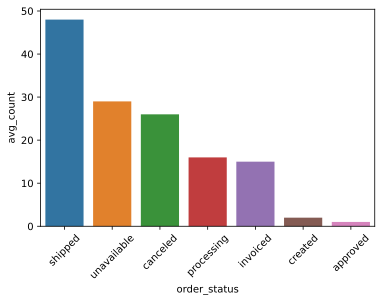

In [39]:
fig, ax = plt.subplots()
sns.barplot(data=avg_no_delivered, x='order_status', y='avg_count')
ax.tick_params(axis='x', rotation=45)

Заказы не были доставлены по логичным причинам, некоторые еще не завершены и находятся в процессе выполнения, часть заказов отменена на определенном этапе (хотелось бы подробнее проанализировать причины отмены, но у нас нет это информации)

### Дополнительно: 
Давайте проанализируем не просто недоставленные заказы, а например несвоевременно доставленные заказы в разрезе городов и штатов. Несвоевременно доставленными заказами будем считать те, у которых доставка покупателю (order_delivered_customer_date) произошла позднее обещанной даты доставки (order_estimated_delivery_date)

In [40]:
orders_customers = orders \
                  .merge(customers, on='customer_id', how='left') 

In [41]:
orders_customers.shape

(99441, 12)

In [42]:
orders_customers['difference'] = orders_customers.order_delivered_customer_date.dt.date - orders_customers.order_estimated_delivery_date.dt.date

In [43]:
orders_customers.query("difference > '0 days'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,d699688533772c15a061e8ce81cb56df,4001,sao paulo,SP,11 days
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03-12,a25d5f94840d3c6a1a49f271ed83f4ec,21715,rio de janeiro,RJ,9 days
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,7 days
57,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,delivered,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02,ddf60e20e6e262e2136801ce5cd628b0,49030,aracaju,SE,1 days
58,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,51838d41add414a0b1b989b7d251d9ee,13068,campinas,SP,7 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99396,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,delivered,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-15 17:42:00,2018-08-21 00:03:26,2018-08-16,f690f0caffab80b6f849f08ba1692925,9330,maua,SP,5 days
99397,0fa1fab1d7c1211c824596ed5e111e3c,7f3bd6c94d2daf7b6462d1a894a775b4,delivered,2018-03-13 21:48:57,2018-03-13 22:40:28,2018-03-14 19:27:23,2018-04-05 19:59:49,2018-04-02,4b855cb19adce3763ce1af3acc2aae0b,3122,sao paulo,SP,3 days
99423,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,delivered,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-10-17 17:04:42,2017-11-21 17:06:59,2017-10-31,a3983b8b6b679c9f645e6ef9517ac98d,14802,araraquara,SP,21 days
99425,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,delivered,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-03-22 21:11:58,2018-04-11 00:48:31,2018-04-09,397cd1affbb66fa8f76e8ac24685440a,13272,valinhos,SP,2 days


In [44]:
# вынесем в отдельный датафрейм заказы, которые доставлены с опозданием
orders_late = orders_customers.query("difference > '0 days'")

In [45]:
orders_late \
        .groupby(['customer_state', 'customer_city'], as_index=False) \
        .agg({'order_id' : 'count'}) \
        .rename(columns={'order_id' : 'count_orders_late'}) \
        .sort_values('count_orders_late', ascending=False) \
        .head(10)

,customer_state,customer_city,count_orders_late
1160,SP,sao paulo,715
746,RJ,rio de janeiro,706
103,BA,salvador,174
314,MG,belo horizonte,137
835,RS,porto alegre,136
1004,SP,campinas,119
178,DF,brasilia,118
724,RJ,niteroi,96
141,CE,fortaleza,94
752,RJ,sao goncalo,83


In [46]:
orders_customers \
        .groupby(['customer_state', 'customer_city'], as_index=False) \
        .agg({'order_id' : 'count'}) \
        .rename(columns={'order_id' : 'count_orders'}) \
        .sort_values('count_orders', ascending=False) \
        .head(10)

,customer_state,customer_city,count_orders
4176,SP,sao paulo,15540
2788,RJ,rio de janeiro,6882
1062,MG,belo horizonte,2773
601,DF,brasilia,2131
2406,PR,curitiba,1521
3729,SP,campinas,1444
3208,RS,porto alegre,1379
372,BA,salvador,1245
3836,SP,guarulhos,1189
4160,SP,sao bernardo do campo,938


Количество несвоевременно доставленных заказов в разрезе штатов и городов пропорционально общему количеству заказов, т.е чем больше количество заказов, тем больше количество несвоевременно доставленных заказов, основными лидерами в обоих случаях являются самые крупные города страны - Сан-Паулу и Рио-де-Жанейро. 

Теперь посмотрим на сколько по времени происходила задержка доставки заказов

In [47]:
orders_late.difference.max()

Timedelta('188 days 00:00:00')

In [48]:
bns = pd.to_timedelta(['1d', '3d', '7d', '14d', '30d', '60d', '90d', '120d', '150d', '190d'])
lab = ['1-3 days', '3-7 days', '7-14 days', '14-30 days', '30-60 days', '60-90 days', '90-120 days', '120-150 days', '150-190 days']
orders_late['categorical'] = pd.cut(orders_late['difference'], bins=bns, labels=lab)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
orders_late_cat = orders_late.groupby('categorical', as_index=False) \
                             .agg({'order_id' : 'count'}) \
                             .rename(columns={'order_id' : 'count'})

In [50]:
orders_late_cat

,categorical,count
0,1-3 days,1045
1,3-7 days,1802
2,7-14 days,1479
3,14-30 days,1039
4,30-60 days,266
5,60-90 days,32
6,90-120 days,21
7,120-150 days,11
8,150-190 days,15


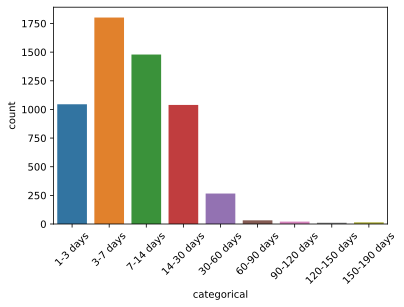

In [51]:
fig, ax = plt.subplots()
sns.barplot(data=orders_late_cat, x='categorical', y='count')
ax.tick_params(axis='x', rotation=45)

Как видим большая часть задержек доставки заказов происходит в интервале до двух недель, однако имеются случаи более длительных задержек. 

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [52]:
# создадим необходимый датафрейм
orders_items = orders.merge(order_items, how='left', on='order_id') \
              [['product_id','order_delivered_customer_date','order_status']]

Так как ранее определились, что покупкой будем считать факт доставки покупателю, то в качестве даты оставляем колонку order_delivered_customer_date

In [53]:
# переведем дату в нужный формат
orders_items['order_delivered_customer_date'] = orders_items['order_delivered_customer_date'].dt.strftime("%A")

In [54]:
orders_items.isna().sum()

product_id                        775
order_delivered_customer_date    3229
order_status                        0
dtype: int64

In [55]:
# удалим пропущенные значения
orders_items = orders_items.dropna()

In [56]:
product_purchase_day = orders_items.query("order_status == 'delivered'") \
            .groupby(['product_id', 'order_delivered_customer_date'], as_index=False) \
            .agg({'order_status' : 'count'}) \
            .drop_duplicates(subset='product_id', keep='first') \
            .sort_values('order_status', ascending=False) \
            .rename(columns={'order_delivered_customer_date' : 'purchase_day'}) \
            [['product_id', 'purchase_day']]

product_purchase_day

,product_id,purchase_day
38745,aca2eb7d00ea1a7b8ebd4e68314663af,Friday
34472,99a4788cb24856965c36a24e339b6058,Friday
12290,368c6c730842d78016ad823897a372db,Friday
12810,389d119b48cf3043d311335e499d9c6b,Friday
18953,53759a2ecddad2bb87a079a1f1519f73,Friday
...,...,...
21486,5e65e068400cdced025ac4801d36ed4d,Friday
21485,5e655ad6a29335c852b7829a5e340c80,Monday
21484,5e653dd3f194d07f140e40878ba2ba5f,Thursday
21482,5e6248437b2668bba62c0fdd71eaf72d,Friday


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

Так как ранее определились, что покупкой будем считать факт доставки покупателю, то работаем с колонкой order_delivered_customer_date

In [57]:
orders_customers.dtypes

order_id                                  object
customer_id                               object
order_status                              object
order_purchase_timestamp          datetime64[ns]
order_approved_at                 datetime64[ns]
order_delivered_carrier_date      datetime64[ns]
order_delivered_customer_date     datetime64[ns]
order_estimated_delivery_date     datetime64[ns]
customer_unique_id                        object
customer_zip_code_prefix                   int64
customer_city                             object
customer_state                            object
difference                       timedelta64[ns]
dtype: object

In [58]:
# возьмем датафрейм из шага 1 и переведем дату в нужный формат
orders_customers.order_delivered_customer_date = orders.order_delivered_customer_date.dt.month_name()

In [59]:
# вычислим количество недель в месяце
orders_customers['weeks'] = orders.order_delivered_customer_date.dt.days_in_month / 7

In [60]:
customer_month = orders_customers \
                .query("order_status == 'delivered'") \
                .groupby(['customer_unique_id', 'order_delivered_customer_date', 'weeks'], as_index=False) \
                .agg({'order_id' : 'count'}) \
                .rename(columns={'order_delivered_customer_date' : 'month', 'order_id' : 'avg_orders'})

In [61]:
customer_month.avg_orders = customer_month.avg_orders / customer_month.weeks

In [62]:
customer_month

,customer_unique_id,month,weeks,avg_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,April,4.285714,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,November,4.285714,0.233333
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,0.233333
...,...,...,...,...
95267,fffcf5a5ff07b0908bd4e2dbc735a684,July,4.428571,0.225806
95268,fffea47cd6d3cc0a88bd621562a9d061,January,4.428571,0.225806
95269,ffff371b4d645b6ecea244b27531430a,February,4.000000,0.250000
95270,ffff5962728ec6157033ef9805bacc48,May,4.428571,0.225806


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.(10 баллов)

Для начала опеределим что такое retention и как его рассчитывать:

Retention: Retention дня X — это N% процентов пользователей, которые вернутся к продукту в день X. Иными словами, если в какой-то конкретный день (день 0) пришло 100 новых пользователей, а на 1-ый день вернулось 15, то Retention 1-го дня составит 15 / 100 = 15%.

In [63]:
# создадим датасет
price = order_items.groupby('order_id').agg({'price' : 'sum'}).reset_index()

In [64]:
delivered = orders.query("order_status == 'delivered'")

In [65]:
orders_price = price.merge(delivered, on='order_id', how='inner') \
                    .merge(customers, on='customer_id', how='inner')

In [66]:
orders_price.shape

(96470, 13)

In [67]:
# переведем формат колонки в месяц
orders_price.order_delivered_customer_date = orders_price.order_delivered_customer_date.dt.strftime('%Y-%m')

In [68]:
# оставим нужные колонки и отсортируем по дате
orders_price = orders_price[['order_id', 'customer_unique_id', 'order_delivered_customer_date', 'price']]
orders_price = orders_price.sort_values('order_delivered_customer_date')

In [69]:
orders_price.head()

,order_id,customer_unique_id,order_delivered_customer_date,price
23846,3f72d2b757e725cd48a4726f831c7789,0829f7df6577d5a4b65439bea701405f,2016-10,249.90
65407,ae0913baa54f18027667d8049c36fde2,0acb54b64345b37d81205175f3f3e779,2016-10,149.99
10270,1b2d622f7ebb8e65f7de3e389f052540,7a2679d6c164f6b6a2f36daf1b2fbc9d,2016-10,40.90
92864,f688669f48063536e082bb32d634cd46,15896826233a6eda72c64e1b99a0856a,2016-10,99.99
47065,7d0eb8de17d494f4151e4470cd1b0605,7fab7e8b8aa68f7a538ca818b7b57322,2016-10,79.90


In [70]:
# создадим датасет с датой первой покупки
first_buy_date = orders_price.groupby('customer_unique_id',as_index=False) \
    .agg({'order_delivered_customer_date':'first'}) \
    .rename(columns={'order_delivered_customer_date' : 'first_buy_date'})
first_buy_date.head()

,customer_unique_id,first_buy_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-04
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [71]:
# добавим полученный датафрейм к основному
orders_price = orders_price.merge(first_buy_date, on='customer_unique_id')

In [72]:
orders_price.head()

,order_id,customer_unique_id,order_delivered_customer_date,price,first_buy_date
0,3f72d2b757e725cd48a4726f831c7789,0829f7df6577d5a4b65439bea701405f,2016-10,249.90,2016-10
1,ae0913baa54f18027667d8049c36fde2,0acb54b64345b37d81205175f3f3e779,2016-10,149.99,2016-10
2,1b2d622f7ebb8e65f7de3e389f052540,7a2679d6c164f6b6a2f36daf1b2fbc9d,2016-10,40.90,2016-10
3,f688669f48063536e082bb32d634cd46,15896826233a6eda72c64e1b99a0856a,2016-10,99.99,2016-10
4,7d0eb8de17d494f4151e4470cd1b0605,7fab7e8b8aa68f7a538ca818b7b57322,2016-10,79.90,2016-10


In [73]:
# сгруппируем данные
orders_price = orders_price.groupby(['first_buy_date','order_delivered_customer_date']) \
    .agg({'customer_unique_id':'count'})
orders_price

customer_unique_id
first_buy_date order_delivered_customer_date                    
2016-10        2016-10                                       205
               2016-11                                         1
               2017-04                                         1
               2017-08                                         1
               2017-10                                         1
...                                                          ...
2018-07        2018-08                                        37
2018-08        2018-08                                      8105
               2018-09                                         1
2018-09        2018-09                                        54
2018-10        2018-10                                         3

[219 rows x 1 columns]

In [74]:
# посчитаем когорту
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

orders_price = orders_price.groupby(level=0).apply(cohort_period)
orders_price.head()

customer_unique_id  \
first_buy_date order_delivered_customer_date                       
2016-10        2016-10                                       205   
               2016-11                                         1   
               2017-04                                         1   
               2017-08                                         1   
               2017-10                                         1   

                                              cohort_period  
first_buy_date order_delivered_customer_date                 
2016-10        2016-10                                    1  
               2016-11                                    2  
               2017-04                                    3  
               2017-08                                    4  
               2017-10                                    5

In [75]:
retention = orders_price.pivot_table(index='first_buy_date', columns='cohort_period', values='customer_unique_id')

In [76]:
# введем единицу для расчета retention
base = retention[1]

In [77]:
retention = retention.divide(base, axis=0).round(4)

In [78]:
retention

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_buy_date,,,,,,,,,,,,,,,,,,
2016-10,1.0,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0098,0.0049,0.0049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.0106,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0071,0.0106,0.0035,0.0071,0.0035,NaN,NaN,NaN,NaN,NaN
2017-02,1.0,0.0067,0.0022,0.0030,0.0030,0.0015,0.0015,0.0022,0.0007,0.0007,0.0015,0.0037,0.0022,0.0015,0.0007,0.0015,0.0022,0.0007
2017-03,1.0,0.0059,0.0030,0.0042,0.0034,0.0008,0.0034,0.0025,0.0034,0.0021,0.0025,0.0004,0.0004,0.0030,0.0013,0.0017,0.0013,0.0008
2017-04,1.0,0.0082,0.0033,0.0022,0.0027,0.0016,0.0027,0.0005,0.0038,0.0022,0.0027,0.0016,0.0011,0.0011,0.0016,0.0022,NaN,NaN
2017-05,1.0,0.0075,0.0035,0.0016,0.0035,0.0043,0.0024,0.0035,0.0021,0.0024,0.0024,0.0030,0.0013,0.0016,0.0019,0.0021,NaN,NaN
2017-06,1.0,0.0072,0.0063,0.0044,0.0041,0.0028,0.0038,0.0019,0.0019,0.0025,0.0016,0.0022,0.0022,0.0025,0.0035,NaN,NaN,NaN


In [79]:
# выявим когорту с самым высоким retantion на 3 месяц
retention[retention[3] == retention[3].max()].index

Index(['2017-06'], dtype='object', name='first_buy_date')

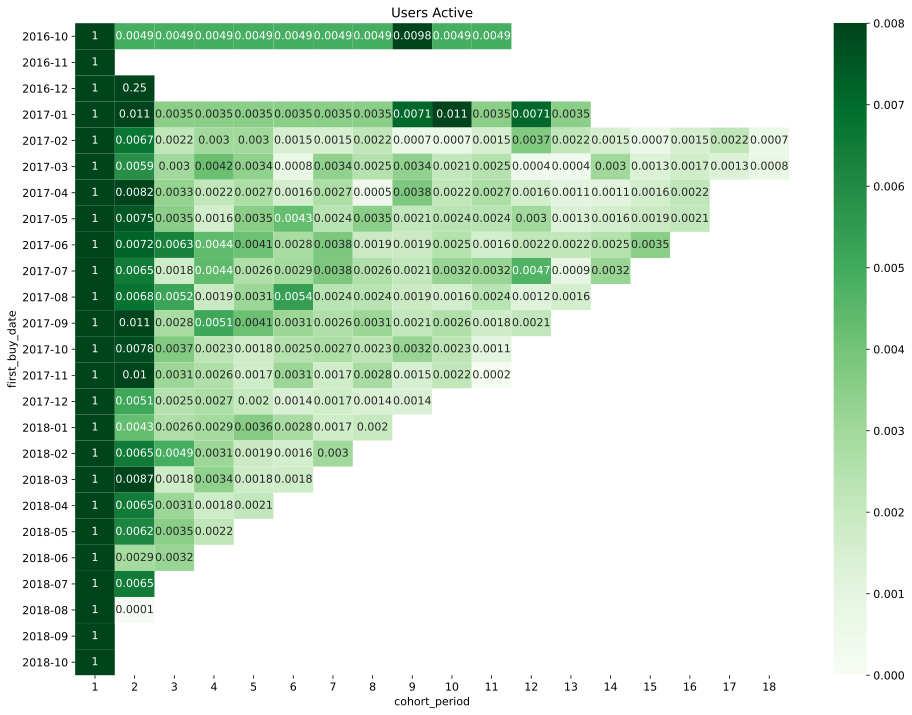

In [80]:
plt.rcParams['font.size'] = '11'
plt.figure(figsize=(16,12))
plt.title('Users Active')
ax = sns.heatmap(data=retention, annot=True, vmin=0.0,vmax=0.008 ,cmap='Greens')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()

plt.show()

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.(35 баллов)

In [81]:
# создадим датасет
monetary = order_items.groupby('order_id').agg({'price' : 'sum'}).reset_index()

In [82]:
# так как мы определились что покупкой считаем факт доставки, то оставим только доставленные заказы
delivered_orders = orders.query("order_status == 'delivered'")

In [83]:
# оставим только необходимые столбцы
orders_monetary = monetary.merge(delivered_orders, on='order_id', how='inner') \
                          .merge(customers, on='customer_id', how='inner') \
                          [['customer_unique_id', 'order_id', 'order_delivered_customer_date', 'price']]

In [84]:
orders_monetary.head()

,customer_unique_id,order_id,order_delivered_customer_date,price
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,58.90
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-05-12 16:04:24,239.90
2,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,199.00
3,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,12.99
4,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-01 16:42:31,199.90


In [85]:
# переведем дату в нужный формат
orders_monetary['order_delivered_customer_date'] = orders_monetary['order_delivered_customer_date'].dt.date

In [86]:
orders_monetary = orders_monetary.groupby(['customer_unique_id', 'order_delivered_customer_date'], as_index=False) \
              .agg({'order_id' : 'count', 'price' : 'sum'}) \
              .drop_duplicates() \
              .rename(columns={'order_delivered_customer_date' : 'order_date', 'order_id' : 'order_count', 'price' : 'revenue'})

orders_monetary.head()

,customer_unique_id,order_date,order_count,revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-16,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-10,1,18.90
2,0000f46a3911fa3c0805444483337064,2017-04-05,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11-01,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-27,1,180.00


Установим Now дату. Эта дата будет использоваться в качестве ориентира для подсчета Recency баллов

In [87]:
Now = orders_monetary['order_date'].max()

In [88]:
# рассчитаем недавность, частоту и денежную стоимость для каждого клиента

orders_monetary = orders_monetary.groupby('customer_unique_id') \
                                 .agg({'order_date' : lambda x: (Now - x.max()).days,
                                       'order_count' : lambda x: len(x),
                                       'revenue' : lambda x: x.sum()})

orders_monetary.head()

,order_date,order_count,revenue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90
0000f46a3911fa3c0805444483337064,560,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99
0004aac84e0df4da2b147fca70cf8255,324,1,180.00


Для расчета баллов R, F и M будем использовать метод квантилей, он является более гибким поскольку диапазоны будут адаптироваться к данным и будут работать в разных отраслях или в случае каких-либо изменений в ожидаемом поведении клиентов.

In [89]:
orders_monetary.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,95%,99%,max
order_date,93350.0,273.960386,151.888486,0.00,50.0,63.0,82.00,153.00,253.0,384.0000,555.000,613.00,736.0
order_count,93350.0,1.030037,0.195882,1.00,1.0,1.0,1.00,1.00,1.0,1.0000,1.000,2.00,14.0
revenue,93350.0,141.620235,215.702028,0.85,12.0,19.8,25.98,47.65,89.7,154.6975,419.833,1004.99,13440.0


In [90]:
bin_labels = ['1', '2', '3', '4']
bin_labels2 = ['1', '4']
bin_labels3 = ['1', '2', '3', '4', '5']
orders_monetary['quantile_recency'] = pd.qcut(orders_monetary['order_date'],
                            q = [0, .10, .25, .50, .75, 1],
                            labels= bin_labels3)
orders_monetary['quantile_frequency'] = pd.qcut(orders_monetary['order_count'],
                            q = [.75, .99, 1],
                            labels= bin_labels2)
orders_monetary['quantile_monetary'] = pd.qcut(orders_monetary['revenue'],
                            q = [0, .25, .5, .75, 1],
                            labels= bin_labels)

orders_monetary['segment_customer'] = orders_monetary['quantile_recency'].astype(str) + orders_monetary['quantile_frequency'].astype(str) \
                             + orders_monetary['quantile_monetary'].astype(str)

orders_monetary.head()

,order_date,order_count,revenue,quantile_recency,quantile_frequency,quantile_monetary,segment_customer
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,3,1,3,313
0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,3,1,1,311
0000f46a3911fa3c0805444483337064,560,1,69.00,5,1,2,512
0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,4,1,1,411
0004aac84e0df4da2b147fca70cf8255,324,1,180.00,4,1,4,414


In [91]:
orders_monetary.segment_customer.value_counts(normalize=True) * 100

412    6.554901
511    6.413498
313    6.328870
311    6.326727
512    6.283878
413    6.256026
314    6.218532
414    6.177825
514    6.166042
411    6.068559
312    5.983931
513    5.976433
213    3.958222
214    3.732191
211    3.695769
212    3.552223
112    2.618104
114    2.536690
111    2.497054
113    2.447777
344    0.050348
444    0.040707
244    0.039636
144    0.022496
544    0.016069
343    0.012855
543    0.005356
443    0.004285
143    0.003214
243    0.003214
142    0.003214
342    0.002142
442    0.001071
542    0.001071
541    0.001071
Name: segment_customer, dtype: float64

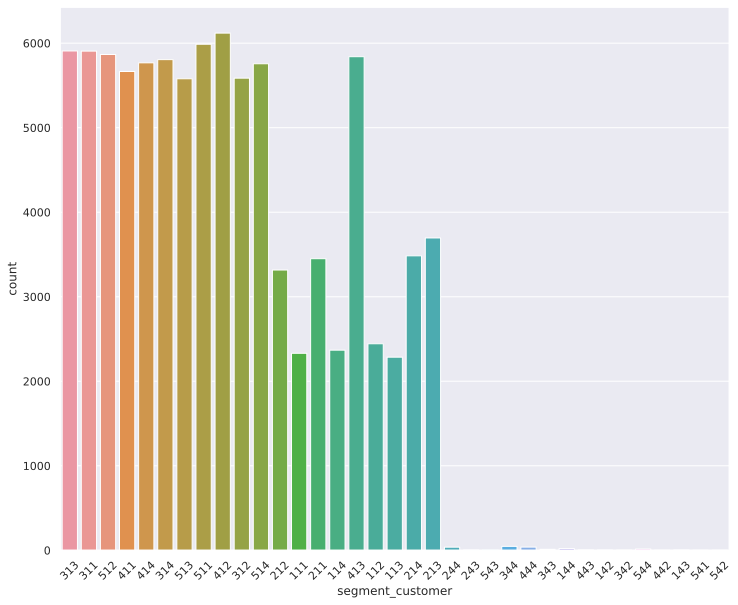

In [92]:
sns.set()
plt.figure(figsize=(12,10))
ax = sns.countplot(x='segment_customer', data=orders_monetary)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

Чем меньше значение quantile_recency, тем лучше, значит такие клиенты покупали недавно, при этом максимальные значения показателей quantile_frequency и quantile_monetary говорят нам о том, что такие клиенты покупали много и дорого. Значит наилучшими являются покупатели, относящиеся к сегменту 144 (совершали покупку менее 3-х месяцев назад, покупали более 1 одного раза на сумму более 155 денежных единиц), но доля таких покупателей у нас к сожалению небольшая (0.02%), там как более 90% клиентов совершили только одну покупку. При этом доля покупателей из сегмента 511 (совершали покупку более 12 месяцев назад, покупали 1 раз на сумму менее 47 денежных единиц), т.е покупали давно, мало и дешево составлят 6.4%.